No video path provided. Using default: /content/ball_tiled_output.mp4
To use a different video, call main('path/to/your/video.mp4')
Video file size: 25.16 MB
Video properties:
- Resolution: 1280x720
- Frame count: 743
- FPS: 30.0
- Duration: 24.766666666666666 seconds
Starting video analysis...
Video info: 743 frames at 30.0 FPS
Processing frame 1/15 (frame #0)

0: 384x640 20 persons, 371.2ms
Speed: 23.3ms preprocess, 371.2ms inference, 48.5ms postprocess per image at shape (1, 3, 384, 640)


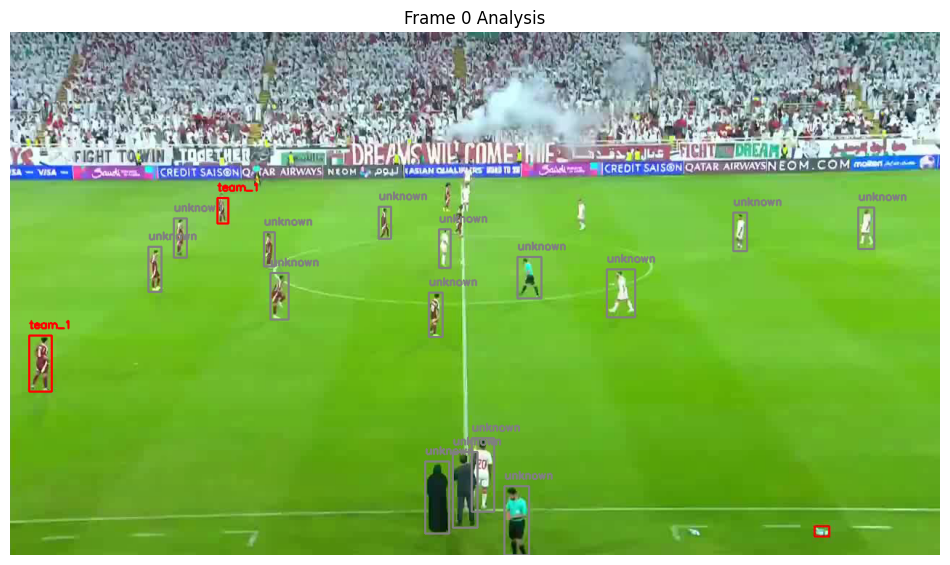

Processing frame 2/15 (frame #53)

0: 384x640 22 persons, 164.5ms
Speed: 4.1ms preprocess, 164.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 3/15 (frame #106)

0: 384x640 15 persons, 3 cars, 158.1ms
Speed: 3.9ms preprocess, 158.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 4/15 (frame #159)

0: 384x640 7 persons, 137.7ms
Speed: 3.9ms preprocess, 137.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


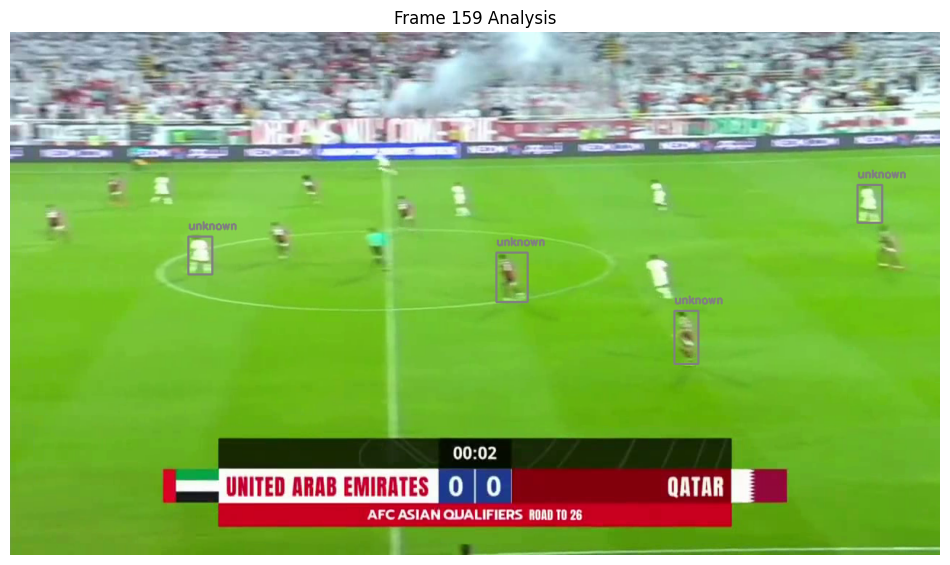

Processing frame 5/15 (frame #212)

0: 384x640 17 persons, 152.3ms
Speed: 3.3ms preprocess, 152.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 6/15 (frame #265)

0: 384x640 14 persons, 141.7ms
Speed: 3.5ms preprocess, 141.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 7/15 (frame #318)

0: 384x640 13 persons, 2 cars, 135.5ms
Speed: 6.7ms preprocess, 135.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


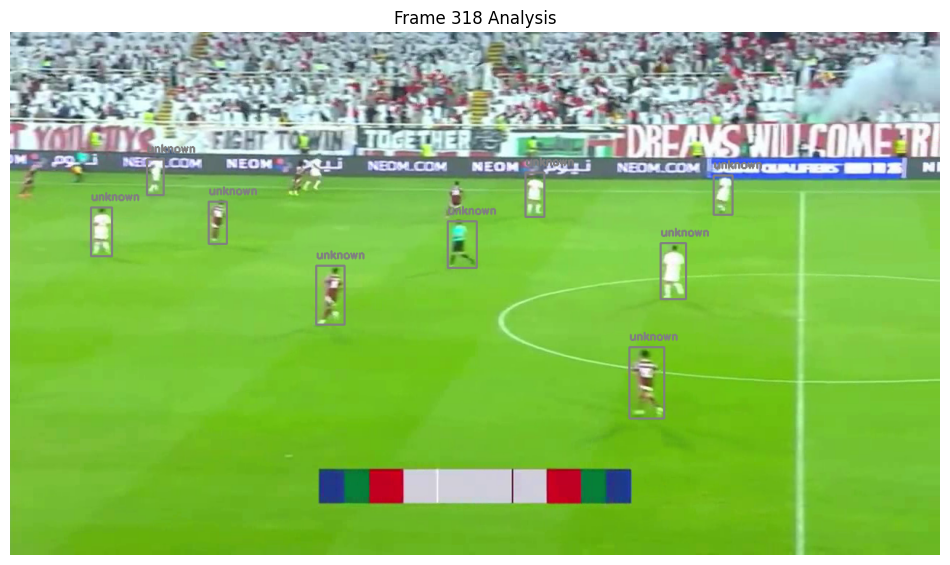

Processing frame 8/15 (frame #371)

0: 384x640 12 persons, 158.0ms
Speed: 3.9ms preprocess, 158.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 9/15 (frame #424)

0: 384x640 18 persons, 164.5ms
Speed: 3.3ms preprocess, 164.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 10/15 (frame #477)

0: 384x640 18 persons, 149.4ms
Speed: 4.6ms preprocess, 149.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


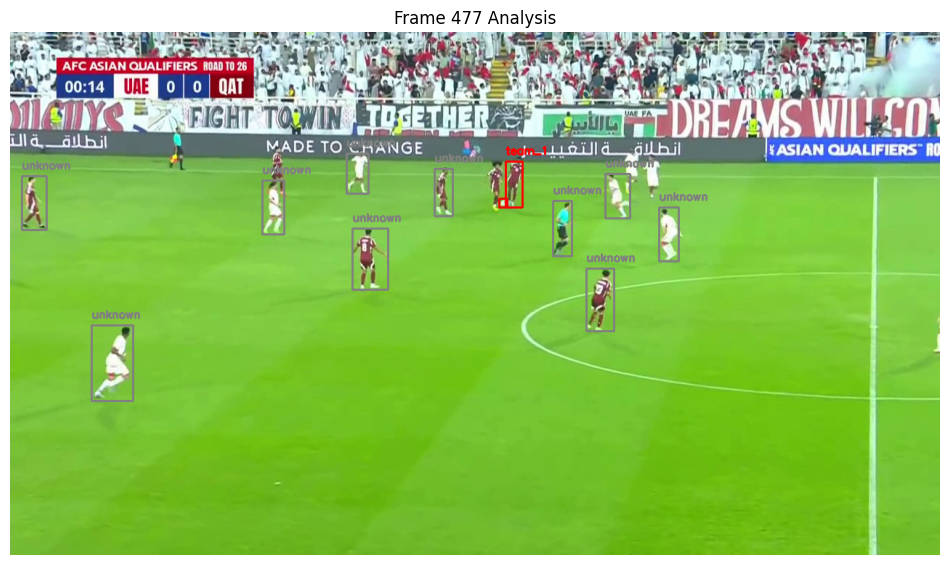

Processing frame 11/15 (frame #530)

0: 384x640 17 persons, 270.7ms
Speed: 3.3ms preprocess, 270.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 12/15 (frame #583)

0: 384x640 17 persons, 1 sports ball, 236.4ms
Speed: 5.4ms preprocess, 236.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 13/15 (frame #636)

0: 384x640 17 persons, 1 baseball glove, 161.5ms
Speed: 3.5ms preprocess, 161.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


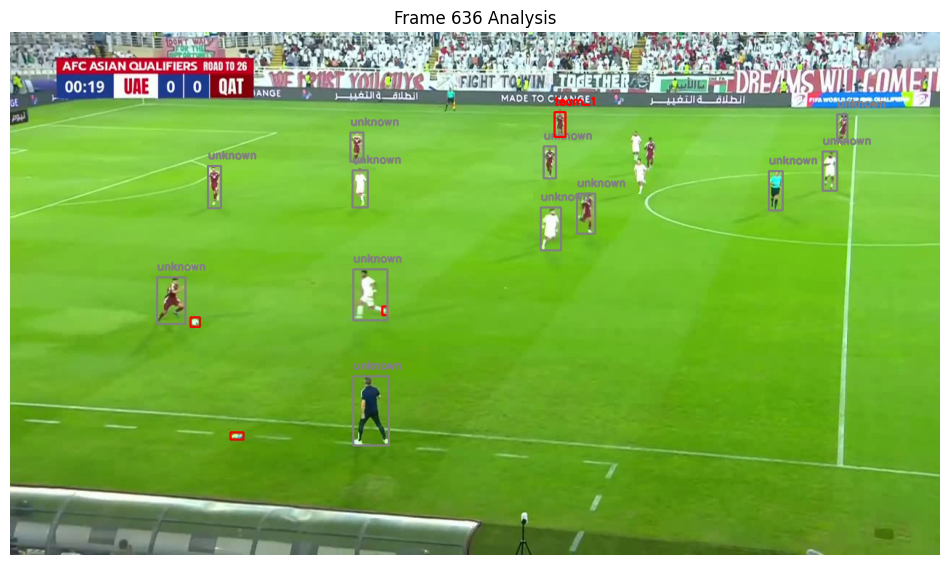

Processing frame 14/15 (frame #689)

0: 384x640 18 persons, 2 sports balls, 196.5ms
Speed: 4.1ms preprocess, 196.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 15/15 (frame #742)

0: 384x640 20 persons, 151.3ms
Speed: 4.0ms preprocess, 151.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
=== SPORTS VIDEO ANALYSIS REPORT ===

Total detections across 15 frames:
- Players: 187
- Referees: 0
- Balls: 0

Team Distribution:
- unknown: 179 detections
- team_1: 6 detections
- team_2: 2 detections

=== END REPORT ===

Results saved to 'sports_analysis_results.csv'
Analysis completed successfully!


In [8]:
# Sports Video Analysis - ML/CV Assessment
# Player Detection, Team Classification, and Jersey Number Recognition

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
from collections import defaultdict
import torch
import torchvision
from torchvision.transforms import transforms
import easyocr
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Install required packages (run in terminal):
# pip install opencv-python matplotlib scikit-learn pandas torch torchvision easyocr pillow ultralytics

class SportsVideoAnalyzer:
    def __init__(self, video_path):
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)

        # Check if video opened successfully
        if not self.cap.isOpened():
            raise ValueError(f"Error: Could not open video file '{video_path}'. "
                           "Please check if the file is corrupted or in an unsupported format.")

        self.frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)

        # Additional validation
        if self.frame_count <= 0:
            raise ValueError(f"Error: Video has {self.frame_count} frames. "
                           "The video file might be corrupted or empty.")

        if self.fps <= 0:
            print(f"Warning: FPS is {self.fps}. Setting default FPS to 30.")
            self.fps = 30.0

        # Initialize YOLO model for object detection
        try:
            from ultralytics import YOLO
            self.yolo_model = YOLO('yolov8n.pt')  # You can use yolov8s.pt for better accuracy
        except:
            print("YOLO not available, using alternative detection method")
            self.yolo_model = None

        # Initialize OCR reader for jersey numbers
        self.ocr_reader = easyocr.Reader(['en'])

        # Color ranges for team classification (adjust based on your teams)
        self.team_colors = {
            'team_1': {'lower': np.array([0, 50, 50]), 'upper': np.array([10, 255, 255])},  # Red team
            'team_2': {'lower': np.array([100, 50, 50]), 'upper': np.array([130, 255, 255])},  # Blue team
            'referee': {'lower': np.array([0, 0, 0]), 'upper': np.array([180, 30, 100])}  # Black/dark colors
        }

    def detect_objects_yolo(self, frame):
        """Detect players, referees, and ball using YOLO"""
        if self.yolo_model is None:
            return self.detect_objects_traditional(frame)

        results = self.yolo_model(frame)
        detections = []

        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    # Get coordinates and confidence
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    conf = box.conf[0].cpu().numpy()
                    cls = int(box.cls[0].cpu().numpy())

                    # YOLO class names (COCO dataset)
                    class_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
                                 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
                                 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                                 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
                                 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
                                 'skis', 'snowboard', 'sports ball']

                    if conf > 0.5:  # Confidence threshold
                        if cls == 0:  # Person class
                            detections.append({
                                'type': 'person',
                                'bbox': [int(x1), int(y1), int(x2), int(y2)],
                                'confidence': conf
                            })
                        elif cls == 32:  # Sports ball class
                            detections.append({
                                'type': 'ball',
                                'bbox': [int(x1), int(y1), int(x2), int(y2)],
                                'confidence': conf
                            })

        return detections

    def detect_objects_traditional(self, frame):
        """Alternative detection method using traditional CV"""
        # Convert to grayscale for contour detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply background subtraction (you might need to initialize this properly)
        # This is a simplified version
        blurred = cv2.GaussianBlur(gray, (11, 11), 0)

        # Edge detection
        edges = cv2.Canny(blurred, 50, 150)

        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detections = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if 1000 < area < 20000:  # Filter by size (adjust based on your video)
                x, y, w, h = cv2.boundingRect(contour)

                # Aspect ratio filtering for people
                aspect_ratio = h / w
                if 1.5 < aspect_ratio < 3.5:  # Typical person aspect ratio
                    detections.append({
                        'type': 'person',
                        'bbox': [x, y, x+w, y+h],
                        'confidence': 0.7
                    })
                elif 0.8 < aspect_ratio < 1.2 and area < 2000:  # Circular objects (ball)
                    detections.append({
                        'type': 'ball',
                        'bbox': [x, y, x+w, y+h],
                        'confidence': 0.6
                    })

        return detections

    def classify_team(self, frame, bbox):
        """Classify team based on jersey color"""
        x1, y1, x2, y2 = bbox

        # Extract person region
        person_roi = frame[y1:y2, x1:x2]

        if person_roi.size == 0:
            return 'unknown'

        # Convert to HSV for better color detection
        hsv = cv2.cvtColor(person_roi, cv2.COLOR_BGR2HSV)

        # Calculate color histograms for each team
        team_scores = {}

        for team, color_range in self.team_colors.items():
            mask = cv2.inRange(hsv, color_range['lower'], color_range['upper'])
            score = np.sum(mask) / (mask.shape[0] * mask.shape[1] * 255)  # Normalize
            team_scores[team] = score

        # Return team with highest score if above threshold
        best_team = max(team_scores, key=team_scores.get)
        if team_scores[best_team] > 0.1:  # Threshold for color presence
            return best_team
        else:
            return 'unknown'

    def detect_jersey_number(self, frame, bbox):
        """Detect and recognize jersey numbers using OCR"""
        x1, y1, x2, y2 = bbox

        # Extract person region
        person_roi = frame[y1:y2, x1:x2]

        if person_roi.size == 0:
            return None

        # Focus on torso area (jersey numbers are typically in the middle)
        h, w = person_roi.shape[:2]
        torso_roi = person_roi[int(h*0.3):int(h*0.7), int(w*0.2):int(w*0.8)]

        try:
            # Use OCR to detect numbers
            results = self.ocr_reader.readtext(torso_roi)

            # Filter for numbers only
            numbers = []
            for (bbox_ocr, text, conf) in results:
                if conf > 0.5:  # Confidence threshold
                    # Extract only digits
                    digits = ''.join(filter(str.isdigit, text))
                    if digits and len(digits) <= 2:  # Jersey numbers are typically 1-2 digits
                        numbers.append(digits)

            return numbers[0] if numbers else None

        except Exception as e:
            print(f"OCR Error: {e}")
            return None

    def process_frame(self, frame_idx):
        """Process a single frame"""
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = self.cap.read()

        if not ret:
            return None

        # Detect objects
        detections = self.detect_objects_yolo(frame)

        frame_results = {
            'frame_idx': frame_idx,
            'players': [],
            'referees': [],
            'balls': []
        }

        for detection in detections:
            if detection['type'] == 'person':
                # Classify team
                team = self.classify_team(frame, detection['bbox'])

                # Detect jersey number
                jersey_number = self.detect_jersey_number(frame, detection['bbox'])

                person_data = {
                    'bbox': detection['bbox'],
                    'team': team,
                    'jersey_number': jersey_number,
                    'confidence': detection['confidence']
                }

                if team == 'referee':
                    frame_results['referees'].append(person_data)
                else:
                    frame_results['players'].append(person_data)

            elif detection['type'] == 'ball':
                frame_results['balls'].append({
                    'bbox': detection['bbox'],
                    'confidence': detection['confidence']
                })

        return frame_results, frame

    def visualize_results(self, frame, results):
        """Visualize detection results on frame"""
        vis_frame = frame.copy()

        # Colors for visualization
        colors = {
            'team_1': (0, 0, 255),    # Red
            'team_2': (255, 0, 0),    # Blue
            'referee': (0, 0, 0),     # Black
            'unknown': (128, 128, 128), # Gray
            'ball': (0, 255, 0)       # Green
        }

        # Draw players
        for player in results['players']:
            x1, y1, x2, y2 = player['bbox']
            team = player['team']
            jersey = player['jersey_number']

            color = colors.get(team, colors['unknown'])
            cv2.rectangle(vis_frame, (x1, y1), (x2, y2), color, 2)

            # Label
            label = f"{team}"
            if jersey:
                label += f" #{jersey}"

            cv2.putText(vis_frame, label, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Draw referees
        for referee in results['referees']:
            x1, y1, x2, y2 = referee['bbox']
            color = colors['referee']
            cv2.rectangle(vis_frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(vis_frame, "Referee", (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Draw balls
        for ball in results['balls']:
            x1, y1, x2, y2 = ball['bbox']
            color = colors['ball']
            cv2.rectangle(vis_frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(vis_frame, "Ball", (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        return vis_frame

    def analyze_video(self, sample_frames=10):
        """Analyze multiple frames from the video"""
        results = []

        # Sample frames evenly across the video
        frame_indices = np.linspace(0, self.frame_count-1, sample_frames, dtype=int)

        for i, frame_idx in enumerate(frame_indices):
            print(f"Processing frame {i+1}/{sample_frames} (frame #{frame_idx})")

            frame_result, frame = self.process_frame(frame_idx)
            if frame_result:
                results.append(frame_result)

                # Visualize every few frames
                if i % 3 == 0:  # Show every 3rd processed frame
                    vis_frame = self.visualize_results(frame, frame_result)

                    plt.figure(figsize=(12, 8))
                    plt.imshow(cv2.cvtColor(vis_frame, cv2.COLOR_BGR2RGB))
                    plt.title(f"Frame {frame_idx} Analysis")
                    plt.axis('off')
                    plt.show()

        return results

    def generate_report(self, results):
        """Generate analysis report"""
        print("=== SPORTS VIDEO ANALYSIS REPORT ===\n")

        total_players = sum(len(r['players']) for r in results)
        total_referees = sum(len(r['referees']) for r in results)
        total_balls = sum(len(r['balls']) for r in results)

        print(f"Total detections across {len(results)} frames:")
        print(f"- Players: {total_players}")
        print(f"- Referees: {total_referees}")
        print(f"- Balls: {total_balls}\n")

        # Team analysis
        team_counts = defaultdict(int)
        jersey_numbers = defaultdict(list)

        for result in results:
            for player in result['players']:
                team = player['team']
                team_counts[team] += 1

                if player['jersey_number']:
                    jersey_numbers[team].append(player['jersey_number'])

        print("Team Distribution:")
        for team, count in team_counts.items():
            print(f"- {team}: {count} detections")

            unique_jerseys = list(set(jersey_numbers[team]))
            if unique_jerseys:
                print(f"  Jersey numbers detected: {sorted(unique_jerseys)}")

        print("\n=== END REPORT ===")

        return {
            'total_frames_analyzed': len(results),
            'total_players': total_players,
            'total_referees': total_referees,
            'total_balls': total_balls,
            'team_distribution': dict(team_counts),
            'jersey_numbers': dict(jersey_numbers)
        }

# Usage Example
def main(video_path=None):
    # Initialize analyzer with your video file
    if video_path is None:
        # You can either specify the path here or pass it as parameter
        video_path = "/content/ball_tiled_output.mp4"  # Replace with your video path
        print(f"No video path provided. Using default: {video_path}")
        print("To use a different video, call main('path/to/your/video.mp4')")

    # Check if video file exists
    import os
    if not os.path.exists(video_path):
        print(f"Error: Video file '{video_path}' not found!")
        print("Please make sure:")
        print("1. The video file path is correct")
        print("2. The file exists and is accessible")
        print("3. You have the correct file permissions")
        return None, None, None

    # Check video file size and properties
    file_size = os.path.getsize(video_path)
    print(f"Video file size: {file_size / (1024*1024):.2f} MB")

    # Try to get basic video info first
    test_cap = cv2.VideoCapture(video_path)
    if not test_cap.isOpened():
        print(f"Error: OpenCV cannot open video file '{video_path}'")
        print("This might be due to:")
        print("1. Unsupported video codec/format")
        print("2. Corrupted video file")
        print("3. Missing video codecs on your system")

        # Try alternative method
        try:
            import subprocess
            result = subprocess.run(['ffprobe', '-v', 'quiet', '-print_format', 'json',
                                   '-show_format', '-show_streams', video_path],
                                   capture_output=True, text=True)
            if result.returncode == 0:
                print("Video file appears valid (detected by ffprobe)")
                print("Try converting to a different format: mp4, avi, or mov")
            else:
                print("Video file appears to be corrupted or invalid")
        except:
            print("Install ffmpeg for better video format support")

        test_cap.release()
        return None, None, None

    # Get video properties
    frame_count = int(test_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = test_cap.get(cv2.CAP_PROP_FPS)
    width = int(test_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(test_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f"Video properties:")
    print(f"- Resolution: {width}x{height}")
    print(f"- Frame count: {frame_count}")
    print(f"- FPS: {fps}")
    print(f"- Duration: {frame_count/fps if fps > 0 else 'Unknown'} seconds")

    test_cap.release()

    if frame_count <= 0 or fps <= 0:
        print("Error: Invalid video properties detected!")
        return None, None, None

    try:
        analyzer = SportsVideoAnalyzer(video_path)

        print("Starting video analysis...")
        print(f"Video info: {analyzer.frame_count} frames at {analyzer.fps} FPS")

        # Analyze video (adjust sample_frames based on video length)
        results = analyzer.analyze_video(sample_frames=15)

        # Generate report
        report = analyzer.generate_report(results)

        # Save results to CSV for further analysis
        df_data = []
        for result in results:
            frame_idx = result['frame_idx']

            for player in result['players']:
                df_data.append({
                    'frame': frame_idx,
                    'type': 'player',
                    'team': player['team'],
                    'jersey_number': player['jersey_number'],
                    'bbox_x1': player['bbox'][0],
                    'bbox_y1': player['bbox'][1],
                    'bbox_x2': player['bbox'][2],
                    'bbox_y2': player['bbox'][3],
                    'confidence': player['confidence']
                })

            for referee in result['referees']:
                df_data.append({
                    'frame': frame_idx,
                    'type': 'referee',
                    'team': 'referee',
                    'jersey_number': referee.get('jersey_number'),
                    'bbox_x1': referee['bbox'][0],
                    'bbox_y1': referee['bbox'][1],
                    'bbox_x2': referee['bbox'][2],
                    'bbox_y2': referee['bbox'][3],
                    'confidence': referee['confidence']
                })

            for ball in result['balls']:
                df_data.append({
                    'frame': frame_idx,
                    'type': 'ball',
                    'team': 'N/A',
                    'jersey_number': 'N/A',
                    'bbox_x1': ball['bbox'][0],
                    'bbox_y1': ball['bbox'][1],
                    'bbox_x2': ball['bbox'][2],
                    'bbox_y2': ball['bbox'][3],
                    'confidence': ball['confidence']
                })

        df = pd.DataFrame(df_data)
        df.to_csv('sports_analysis_results.csv', index=False)
        print("\nResults saved to 'sports_analysis_results.csv'")

        return analyzer, results, report

    except Exception as e:
        print(f"Error: {e}")
        print("Make sure to:")
        print("1. Install required packages")
        print("2. Provide correct video path")
        print("3. Have sufficient memory for video processing")
        return None, None, None

if __name__ == "__main__":
    # Run the analysis
    result = main()
    if result[0] is not None:
        analyzer, results, report = result
        print("Analysis completed successfully!")
    else:
        print("Analysis failed. Please check the error messages above.")

In [3]:
pip install opencv-python matplotlib scikit-learn pandas torch torchvision easyocr pillow ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8

Processing frame 1/15 (frame #0)

0: 384x640 20 persons, 160.5ms
Speed: 3.5ms preprocess, 160.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


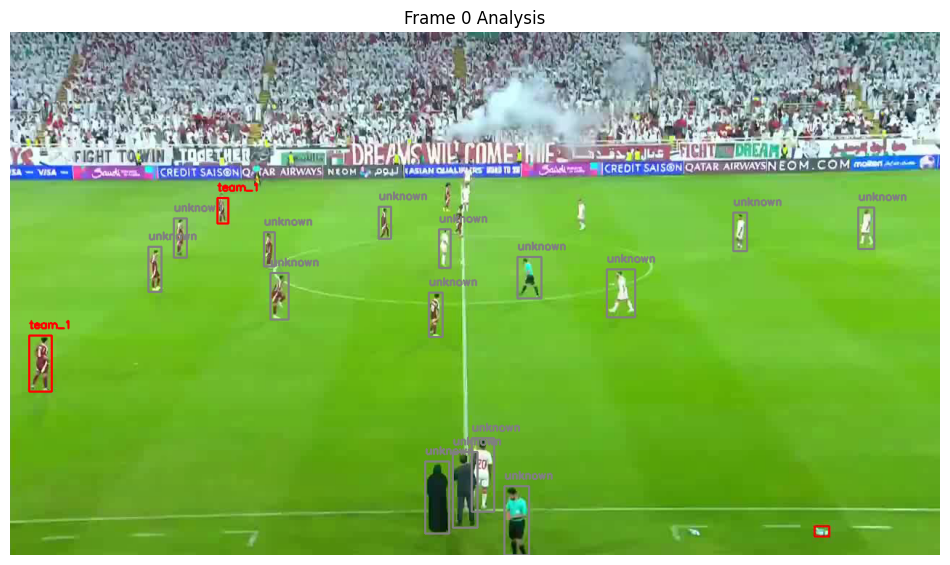

Processing frame 2/15 (frame #53)

0: 384x640 22 persons, 153.3ms
Speed: 3.4ms preprocess, 153.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 3/15 (frame #106)

0: 384x640 15 persons, 3 cars, 144.7ms
Speed: 4.3ms preprocess, 144.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 4/15 (frame #159)

0: 384x640 7 persons, 154.6ms
Speed: 3.8ms preprocess, 154.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


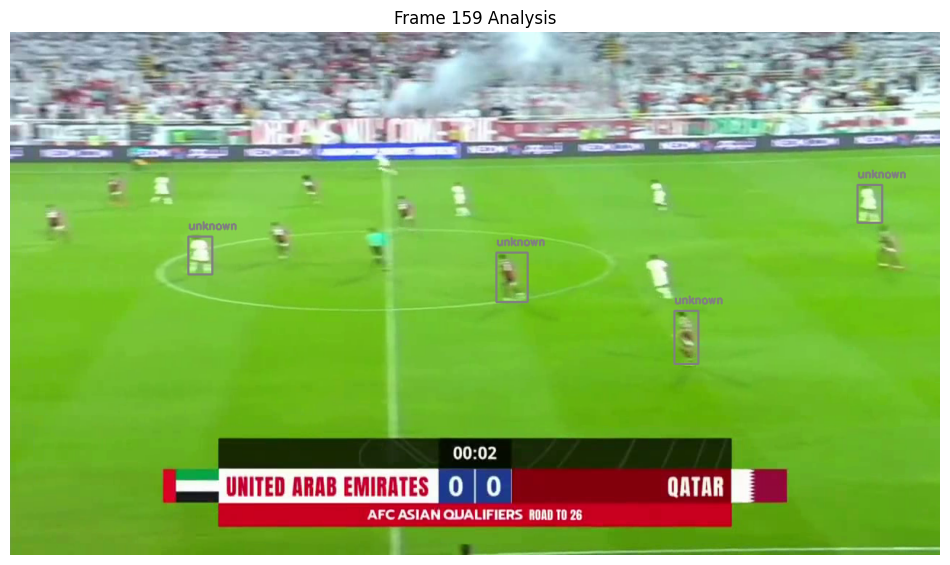

Processing frame 5/15 (frame #212)

0: 384x640 17 persons, 152.2ms
Speed: 3.2ms preprocess, 152.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 6/15 (frame #265)

0: 384x640 14 persons, 140.6ms
Speed: 5.6ms preprocess, 140.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 7/15 (frame #318)

0: 384x640 13 persons, 2 cars, 158.5ms
Speed: 4.0ms preprocess, 158.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


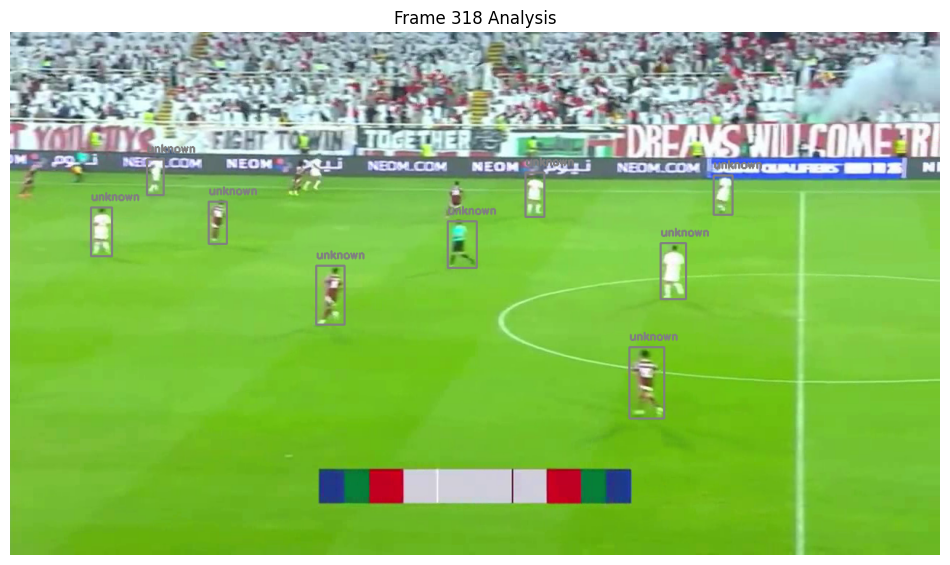

Processing frame 8/15 (frame #371)

0: 384x640 12 persons, 213.4ms
Speed: 3.3ms preprocess, 213.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 9/15 (frame #424)

0: 384x640 18 persons, 235.0ms
Speed: 4.7ms preprocess, 235.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 10/15 (frame #477)

0: 384x640 18 persons, 230.7ms
Speed: 4.0ms preprocess, 230.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


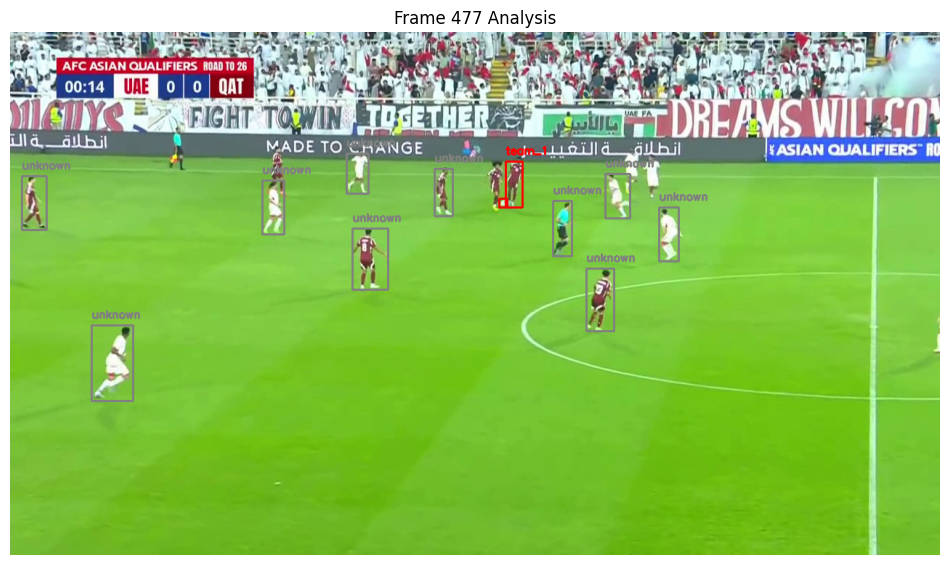

Processing frame 11/15 (frame #530)

0: 384x640 17 persons, 178.2ms
Speed: 3.3ms preprocess, 178.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 12/15 (frame #583)

0: 384x640 17 persons, 1 sports ball, 165.3ms
Speed: 3.7ms preprocess, 165.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 13/15 (frame #636)

0: 384x640 17 persons, 1 baseball glove, 151.9ms
Speed: 4.6ms preprocess, 151.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


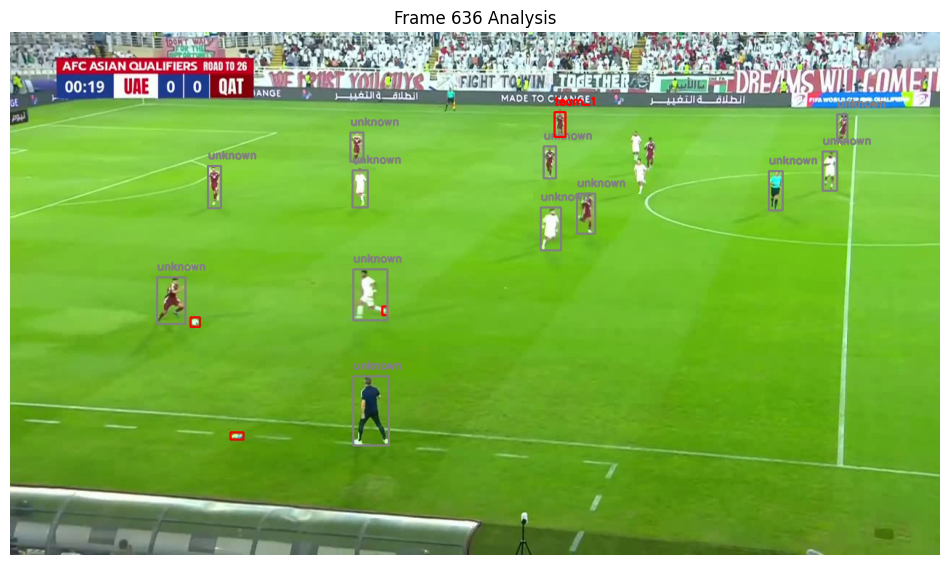

Processing frame 14/15 (frame #689)

0: 384x640 18 persons, 2 sports balls, 187.8ms
Speed: 3.6ms preprocess, 187.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 15/15 (frame #742)

0: 384x640 20 persons, 153.2ms
Speed: 3.9ms preprocess, 153.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

✅ Output video saved as: sports_output.mp4
=== SPORTS VIDEO ANALYSIS REPORT ===

Players: 187, Referees: 0, Balls: 0

unknown: 179 detections, Jerseys: []
team_1: 6 detections, Jerseys: []
team_2: 2 detections, Jerseys: []
Analysis completed successfully!


In [10]:
# Sports Video Analysis - ML/CV Assessment
# Player Detection, Team Classification, and Jersey Number Recognition with Video Output
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
from collections import defaultdict
import torch
import torchvision
from torchvision.transforms import transforms
import easyocr
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

class SportsVideoAnalyzer:
    def __init__(self, video_path):
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)

        if not self.cap.isOpened():
            raise ValueError(f"Error: Could not open video file '{video_path}'.")

        self.frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)

        if self.frame_count <= 0:
            raise ValueError("Error: Video appears empty or corrupted.")

        if self.fps <= 0:
            self.fps = 30.0

        from ultralytics import YOLO
        self.yolo_model = YOLO('yolov8n.pt')

        self.ocr_reader = easyocr.Reader(['en'])

        self.team_colors = {
            'team_1': {'lower': np.array([0, 50, 50]), 'upper': np.array([10, 255, 255])},
            'team_2': {'lower': np.array([100, 50, 50]), 'upper': np.array([130, 255, 255])},
            'referee': {'lower': np.array([0, 0, 0]), 'upper': np.array([180, 30, 100])}
        }

    def detect_objects_yolo(self, frame):
        results = self.yolo_model(frame)
        detections = []
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    conf = box.conf[0].cpu().numpy()
                    cls = int(box.cls[0].cpu().numpy())
                    if conf > 0.5:
                        if cls == 0:
                            detections.append({'type': 'person', 'bbox': [int(x1), int(y1), int(x2), int(y2)], 'confidence': conf})
                        elif cls == 32:
                            detections.append({'type': 'ball', 'bbox': [int(x1), int(y1), int(x2), int(y2)], 'confidence': conf})
        return detections

    def classify_team(self, frame, bbox):
        x1, y1, x2, y2 = bbox
        person_roi = frame[y1:y2, x1:x2]
        if person_roi.size == 0:
            return 'unknown'
        hsv = cv2.cvtColor(person_roi, cv2.COLOR_BGR2HSV)
        team_scores = {}
        for team, color_range in self.team_colors.items():
            mask = cv2.inRange(hsv, color_range['lower'], color_range['upper'])
            score = np.sum(mask) / (mask.shape[0] * mask.shape[1] * 255)
            team_scores[team] = score
        best_team = max(team_scores, key=team_scores.get)
        return best_team if team_scores[best_team] > 0.1 else 'unknown'

    def detect_jersey_number(self, frame, bbox):
        x1, y1, x2, y2 = bbox
        person_roi = frame[y1:y2, x1:x2]
        if person_roi.size == 0:
            return None
        h, w = person_roi.shape[:2]
        torso_roi = person_roi[int(h*0.3):int(h*0.7), int(w*0.2):int(w*0.8)]
        try:
            results = self.ocr_reader.readtext(torso_roi)
            numbers = []
            for (_, text, conf) in results:
                if conf > 0.5:
                    digits = ''.join(filter(str.isdigit, text))
                    if digits and len(digits) <= 2:
                        numbers.append(digits)
            return numbers[0] if numbers else None
        except:
            return None

    def process_frame(self, frame_idx):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = self.cap.read()
        if not ret:
            return None, None
        detections = self.detect_objects_yolo(frame)
        frame_results = {'frame_idx': frame_idx, 'players': [], 'referees': [], 'balls': []}
        for detection in detections:
            if detection['type'] == 'person':
                team = self.classify_team(frame, detection['bbox'])
                jersey_number = self.detect_jersey_number(frame, detection['bbox'])
                data = {'bbox': detection['bbox'], 'team': team, 'jersey_number': jersey_number, 'confidence': detection['confidence']}
                if team == 'referee':
                    frame_results['referees'].append(data)
                else:
                    frame_results['players'].append(data)
            elif detection['type'] == 'ball':
                frame_results['balls'].append({'bbox': detection['bbox'], 'confidence': detection['confidence']})
        return frame_results, frame

    def visualize_results(self, frame, results):
        vis_frame = frame.copy()
        colors = {'team_1': (0, 0, 255), 'team_2': (255, 0, 0), 'referee': (0, 0, 0), 'unknown': (128, 128, 128), 'ball': (0, 255, 0)}
        for player in results['players']:
            x1, y1, x2, y2 = player['bbox']
            color = colors.get(player['team'], colors['unknown'])
            label = f"{player['team']}"
            if player['jersey_number']:
                label += f" #{player['jersey_number']}"
            cv2.rectangle(vis_frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(vis_frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        for referee in results['referees']:
            x1, y1, x2, y2 = referee['bbox']
            cv2.rectangle(vis_frame, (x1, y1), (x2, y2), colors['referee'], 2)
            cv2.putText(vis_frame, "Referee", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors['referee'], 2)
        for ball in results['balls']:
            x1, y1, x2, y2 = ball['bbox']
            cv2.rectangle(vis_frame, (x1, y1), (x2, y2), colors['ball'], 2)
            cv2.putText(vis_frame, "Ball", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors['ball'], 2)
        return vis_frame

    def analyze_video(self, sample_frames=10, output_video_path="output_analysis.mp4"):
        results = []
        frame_indices = np.linspace(0, self.frame_count - 1, sample_frames, dtype=int)
        width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), self.fps, (width, height))
        for i, frame_idx in enumerate(frame_indices):
            print(f"Processing frame {i+1}/{sample_frames} (frame #{frame_idx})")
            frame_result, frame = self.process_frame(frame_idx)
            if frame_result:
                results.append(frame_result)
                vis_frame = self.visualize_results(frame, frame_result)
                out.write(vis_frame)
                if i % 3 == 0:
                    plt.figure(figsize=(12, 8))
                    plt.imshow(cv2.cvtColor(vis_frame, cv2.COLOR_BGR2RGB))
                    plt.title(f"Frame {frame_idx} Analysis")
                    plt.axis('off')
                    plt.show()
        out.release()
        print(f"\n✅ Output video saved as: {output_video_path}")
        return results

    def generate_report(self, results):
        print("=== SPORTS VIDEO ANALYSIS REPORT ===\n")
        total_players = sum(len(r['players']) for r in results)
        total_referees = sum(len(r['referees']) for r in results)
        total_balls = sum(len(r['balls']) for r in results)
        print(f"Players: {total_players}, Referees: {total_referees}, Balls: {total_balls}\n")
        team_counts = defaultdict(int)
        jersey_numbers = defaultdict(list)
        for result in results:
            for player in result['players']:
                team_counts[player['team']] += 1
                if player['jersey_number']:
                    jersey_numbers[player['team']].append(player['jersey_number'])
        for team, count in team_counts.items():
            print(f"{team}: {count} detections, Jerseys: {sorted(set(jersey_numbers[team]))}")
        return {
            'total_players': total_players,
            'total_referees': total_referees,
            'total_balls': total_balls,
            'team_distribution': dict(team_counts),
            'jersey_numbers': dict(jersey_numbers)
        }

def main(video_path="/content/ball_tiled_output.mp4"):
    if not os.path.exists(video_path):
        print(f"Video file '{video_path}' not found.")
        return None, None, None
    analyzer = SportsVideoAnalyzer(video_path)
    results = analyzer.analyze_video(sample_frames=15, output_video_path="sports_output.mp4")
    report = analyzer.generate_report(results)
    return analyzer, results, report

if __name__ == "__main__":
    result = main()
    if result[0] is not None:
        analyzer, results, report = result
        print("Analysis completed successfully!")
